In [1]:
# 1. Import Library & Setup
import os
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_fscore_support
from scipy.sparse import hstack, csr_matrix
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed untuk reprodusibilitas
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


[nltk_data] Downloading package stopwords to /home/kou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Ukuran dataset: (5796, 2)
                                                text  target
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...       0
1  From gort44@excite.com Mon Jun 24 17:54:21 200...       1
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...       1
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...       1
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5796 non-null   object
 1   target  5796 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.7+ KB
None
target
0    3900
1    1896
Name: count, dtype: int64


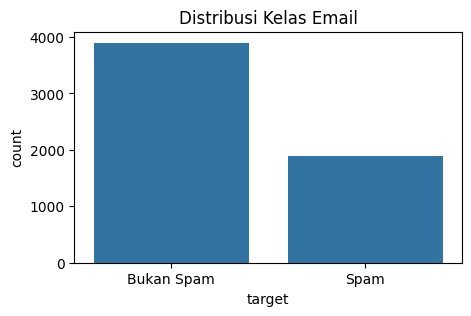

In [2]:
# 2. Memuat Dataset & Eksplorasi Awal
dataFrame = pd.read_csv("Dataset/spam_assassin.csv")
print(f"Ukuran dataset: {dataFrame.shape}")
print(dataFrame.head())
print(dataFrame.info())
print(dataFrame['target'].value_counts())

# Visualisasi distribusi kelas
plt.figure(figsize=(5,3))
sns.countplot(x='target', data=dataFrame)
plt.xticks([0,1], ['Bukan Spam', 'Spam'])
plt.title('Distribusi Kelas Email')
plt.show()


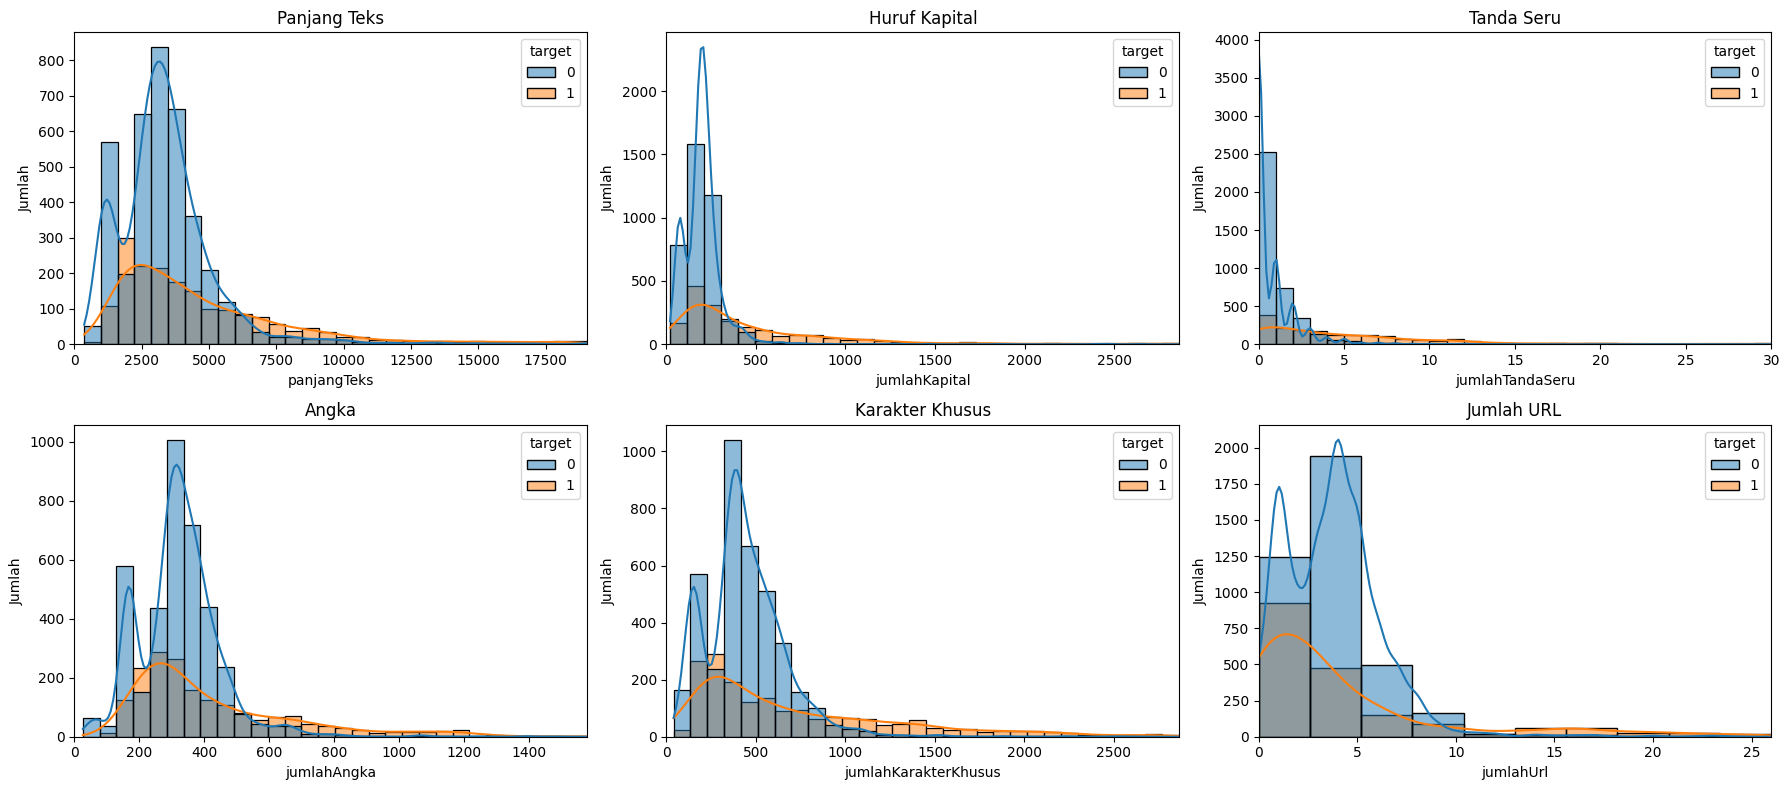

In [3]:
# 3. Rekayasa Fitur Numerik

dataFrame['panjangTeks'] = dataFrame['text'].apply(len)
dataFrame['jumlahKapital'] = dataFrame['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
dataFrame['jumlahTandaSeru'] = dataFrame['text'].apply(lambda x: x.count('!'))
dataFrame['jumlahAngka'] = dataFrame['text'].apply(lambda x: sum(1 for c in x if c.isdigit()))
dataFrame['jumlahKarakterKhusus'] = dataFrame['text'].apply(lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace()))
dataFrame['jumlahUrl'] = dataFrame['text'].apply(lambda x: len(re.findall(r'http[s]?://', x)))
dataFrame['jumlahKata'] = dataFrame['text'].apply(lambda x: len(x.split()))

# Visualisasi fitur numerik dengan pembatasan xlim agar distribusi lebih proporsional
def plot_histogram_fitur(df, fitur, ax, judul, bins=30, persentil_max=99):
    batas = np.percentile(df[fitur], persentil_max)
    sns.histplot(df[df[fitur] <= batas], x=fitur, hue='target', bins=bins, ax=ax, kde=True)
    ax.set_xlim([0, batas])
    ax.set_title(judul)
    ax.set_ylabel('Jumlah')
    ax.set_xlabel(fitur)

gambar, axes = plt.subplots(2, 3, figsize=(18,8))
plot_histogram_fitur(dataFrame, 'panjangTeks', axes[0,0], 'Panjang Teks')
plot_histogram_fitur(dataFrame, 'jumlahKapital', axes[0,1], 'Huruf Kapital')
plot_histogram_fitur(dataFrame, 'jumlahTandaSeru', axes[0,2], 'Tanda Seru', persentil_max=99)
plot_histogram_fitur(dataFrame, 'jumlahAngka', axes[1,0], 'Angka', persentil_max=99)
plot_histogram_fitur(dataFrame, 'jumlahKarakterKhusus', axes[1,1], 'Karakter Khusus', persentil_max=99)
plot_histogram_fitur(dataFrame, 'jumlahUrl', axes[1,2], 'Jumlah URL', bins=10, persentil_max=99)
plt.tight_layout()
plt.show()


In [4]:
# 4. Pra-pemrosesan Teks Lanjutan
def bersihkanTeks(teks, gunakanStem=True, gunakanLemma=False):
    teks = teks.lower()
    teks = re.sub(r'http[s]?://\S+', ' url ', teks)  # ganti URL
    teks = re.sub(r'\d+', ' ', teks)                # hapus angka
    teks = re.sub(r'[^a-z ]', ' ', teks)             # hanya huruf
    kata = teks.split()
    stopWords = set(stopwords.words('english'))
    kata = [w for w in kata if w not in stopWords]
    if gunakanStem:
        stemmer = PorterStemmer()
        kata = [stemmer.stem(w) for w in kata]
    if gunakanLemma:
        lemmatizer = WordNetLemmatizer()
        kata = [lemmatizer.lemmatize(w) for w in kata]
    return ' '.join(kata)

dataFrame['teksBersih'] = dataFrame['text'].apply(lambda x: bersihkanTeks(x, gunakanStem=True, gunakanLemma=False))
print(dataFrame[['text', 'teksBersih']].head())


                                                text  \
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...   
1  From gort44@excite.com Mon Jun 24 17:54:21 200...   
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...   
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...   
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...   

                                          teksBersih  
0  ilug admin linux ie mon jul return path ilug a...  
1  gort excit com mon jun return path gort excit ...  
2  fork admin xent com mon jul return path fork a...  
3  dcm btamail net cn mon jun return path dcm bta...  
4  ilug admin linux ie mon aug return path ilug a...  


In [5]:
# 5. Vektorisasi TF-IDF & Matriks Fitur
vektorizer = TfidfVectorizer(max_features=4000, ngram_range=(1,2), sublinear_tf=True)
Xtfidf = vektorizer.fit_transform(dataFrame['teksBersih'])

# Gabungkan dengan fitur numerik
daftarFiturNumerik = ['panjangTeks', 'jumlahKapital', 'jumlahTandaSeru', 'jumlahAngka', 'jumlahKarakterKhusus', 'jumlahUrl', 'jumlahKata']
Xnumerik = dataFrame[daftarFiturNumerik].values
X = hstack([Xtfidf, csr_matrix(Xnumerik)])
y = dataFrame['target']
print(f"Bentuk matriks fitur: {X.shape}")


Bentuk matriks fitur: (5796, 4007)


In [6]:
# 6. Split Data Latih dan Uji
Xlatih, Xuji, yLatih, yUji = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Data latih: {Xlatih.shape}, Data uji: {Xuji.shape}")


Data latih: (4636, 4007), Data uji: (1160, 4007)


## Model: Naive Bayes

Akurasi   : 0.8009
Presisi   : 0.9512
Recall    : 0.4116
F1-Score  : 0.5746
------------------------------------------------------------

**Classification Report:**
              precision    recall  f1-score   support

  Bukan Spam       0.78      0.99      0.87       781
        Spam       0.95      0.41      0.57       379

    accuracy                           0.80      1160
   macro avg       0.86      0.70      0.72      1160
weighted avg       0.83      0.80      0.77      1160



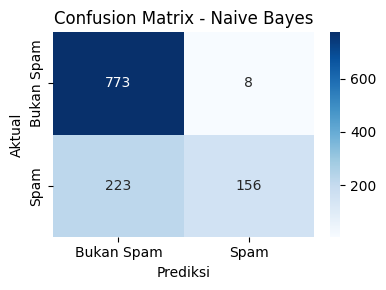

ROC-AUC   : 0.8211


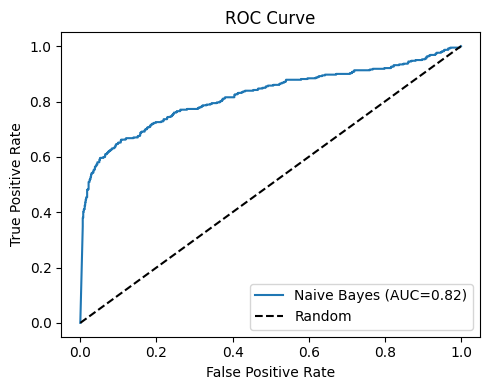

## Model: Support Vector Machine

Akurasi   : 0.9793
Presisi   : 0.9917
Recall    : 0.9446
F1-Score  : 0.9676
------------------------------------------------------------

**Classification Report:**
              precision    recall  f1-score   support

  Bukan Spam       0.97      1.00      0.98       781
        Spam       0.99      0.94      0.97       379

    accuracy                           0.98      1160
   macro avg       0.98      0.97      0.98      1160
weighted avg       0.98      0.98      0.98      1160



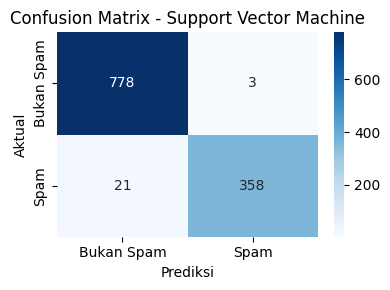

ROC-AUC   : 0.9977


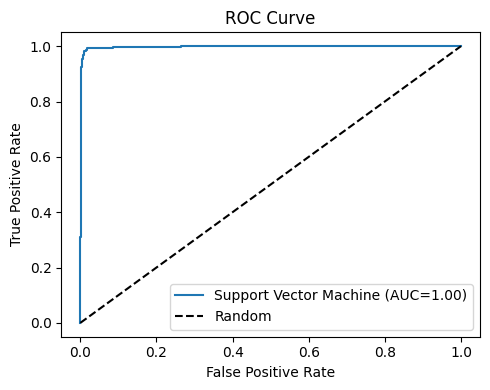

## Model: Decision Tree

Akurasi   : 0.9819
Presisi   : 0.9735
Recall    : 0.9710
F1-Score  : 0.9723
------------------------------------------------------------

**Classification Report:**
              precision    recall  f1-score   support

  Bukan Spam       0.99      0.99      0.99       781
        Spam       0.97      0.97      0.97       379

    accuracy                           0.98      1160
   macro avg       0.98      0.98      0.98      1160
weighted avg       0.98      0.98      0.98      1160



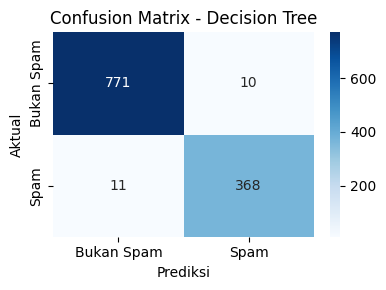

ROC-AUC   : 0.9760


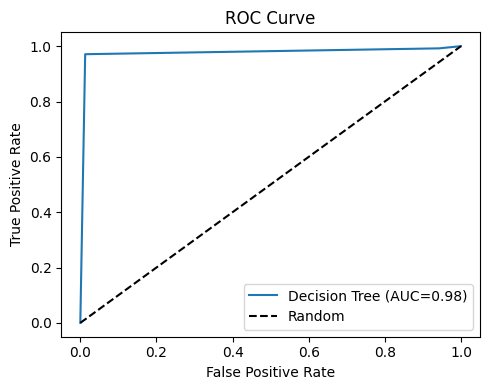

## Model: Voting Ensemble

Akurasi   : 0.9767
Presisi   : 0.9916
Recall    : 0.9367
F1-Score  : 0.9634
------------------------------------------------------------

**Classification Report:**
              precision    recall  f1-score   support

  Bukan Spam       0.97      1.00      0.98       781
        Spam       0.99      0.94      0.96       379

    accuracy                           0.98      1160
   macro avg       0.98      0.97      0.97      1160
weighted avg       0.98      0.98      0.98      1160



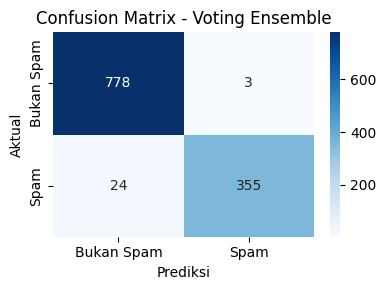

In [7]:
# 7. Pelatihan & Evaluasi Model

def evaluasiModel(nama, model, Xlatih, yLatih, Xuji, yUji):
    from IPython.display import display, Markdown
    model.fit(Xlatih, yLatih)
    yPred = model.predict(Xuji)
    akurasi = accuracy_score(yUji, yPred)
    presisi, recall, f1, _ = precision_recall_fscore_support(yUji, yPred, average='binary')
    display(Markdown(f"## Model: {nama}"))
    print("="*60)
    print(f"Akurasi   : {akurasi:.4f}")
    print(f"Presisi   : {presisi:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print("-"*60)
    print("\n**Classification Report:**")
    print(classification_report(yUji, yPred, target_names=["Bukan Spam", "Spam"]))
    cm = confusion_matrix(yUji, yPred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bukan Spam", "Spam"], yticklabels=["Bukan Spam", "Spam"])
    plt.title(f"Confusion Matrix - {nama}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()
    plt.show()
    # ROC-AUC
    if hasattr(model, "predict_proba"):
        yProb = model.predict_proba(Xuji)[:,1]
    elif hasattr(model, "decision_function"):
        yProb = model.decision_function(Xuji)
    else:
        yProb = None
    if yProb is not None:
        auc = roc_auc_score(yUji, yProb)
        print(f"ROC-AUC   : {auc:.4f}")
        fpr, tpr, _ = roc_curve(yUji, yProb)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{nama} (AUC={auc:.2f})")
        plt.plot([0,1],[0,1],'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.tight_layout()
        plt.show()
    print("\n"+"="*60+"\n")
    return akurasi, presisi, recall, f1

modelKlasifikasi = {
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=20)
}
hasilModel = {}
for nama, model in modelKlasifikasi.items():
    hasilModel[nama] = evaluasiModel(nama, model, Xlatih, yLatih, Xuji, yUji)

# Voting Ensemble
ensemble = VotingClassifier(estimators=[
    ("nb", modelKlasifikasi["Naive Bayes"]),
    ("svm", modelKlasifikasi["Support Vector Machine"]),
    ("dt", modelKlasifikasi["Decision Tree"])
], voting='hard')
hasilModel["Voting Ensemble"] = evaluasiModel("Voting Ensemble", ensemble, Xlatih, yLatih, Xuji, yUji)


In [8]:
# 8. Cross-Validation & Tuning Hyperparameter
for nama, model in modelKlasifikasi.items():
    skor = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{nama} - Akurasi cross-validation: {skor.mean():.4f} ± {skor.std():.4f}")

# Contoh tuning hyperparameter untuk Decision Tree
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid={"max_depth": [5, 10, 20, 30], "min_samples_split": [2, 5, 10]},
    cv=3, scoring='accuracy', n_jobs=-1
)
grid.fit(Xlatih, yLatih)
print(f"Parameter terbaik Decision Tree: {grid.best_params_}, Skor terbaik: {grid.best_score_:.4f}")


Naive Bayes - Akurasi cross-validation: 0.8043 ± 0.0047
Support Vector Machine - Akurasi cross-validation: 0.9896 ± 0.0036
Decision Tree - Akurasi cross-validation: 0.9831 ± 0.0034
Parameter terbaik Decision Tree: {'max_depth': 20, 'min_samples_split': 2}, Skor terbaik: 0.9823


In [9]:
# 9. Analisis Fitur Penting

def tampilkanFiturPenting(vektorizer, model, n=15):
    if hasattr(model, "coef_"):
        namaFitur = list(vektorizer.get_feature_names_out()) + daftarFiturNumerik
        koef = model.coef_[0]
        topPos = np.argsort(koef)[-n:]
        topNeg = np.argsort(koef)[:n]
        print("Fitur paling berkontribusi ke spam:")
        for i in reversed(topPos):
            print(f"{namaFitur[i]}: {koef[i]:.2f}")
        print("\nFitur paling berkontribusi ke bukan spam:")
        for i in topNeg:
            print(f"{namaFitur[i]}: {koef[i]:.2f}")
    elif hasattr(model, "feature_importances_"):
        namaFitur = list(vektorizer.get_feature_names_out()) + daftarFiturNumerik
        importansi = model.feature_importances_
        indeks = np.argsort(importansi)[-n:]
        print("Fitur terpenting:")
        for i in reversed(indeks):
            print(f"{namaFitur[i]}: {importansi[i]:.2f}")

print("\n=== Fitur Penting untuk SVM ===")
tampilkanFiturPenting(vektorizer, modelKlasifikasi["Support Vector Machine"], n=15)
print("\n=== Fitur Penting untuk Decision Tree ===")
tampilkanFiturPenting(vektorizer, modelKlasifikasi["Decision Tree"], n=15)



=== Fitur Penting untuk SVM ===
Fitur paling berkontribusi ke spam:
zzzz: 0.67
zzzz localhost: 0.59
remov: 0.56
pleas: 0.53
free: 0.53
br: 0.52
click: 0.51
font: 0.50
webnot: 0.46
webnot net: 0.46
jun: 0.45
money: 0.44
mandark lab: 0.42
mandark: 0.42
href: 0.41

Fitur paling berkontribusi ke bukan spam:
oct: -0.45
rssfeed: -0.41
list: -0.39
user: -0.38
admin: -0.36
jm localhost: -0.36
tim: -0.36
spambay: -0.36
comcast: -0.35
comcast net: -0.35
yahoogroup com: -0.34
yahoogroup: -0.34
zzzzteana: -0.34
rssfeed spamassassin: -0.34
spam: -0.34

=== Fitur Penting untuk Decision Tree ===
Fitur terpenting:
imap: 0.48
text html: 0.15
zzzzason: 0.08
spambay: 0.08
archiv: 0.03
lab spamassassin: 0.03
jm netnoteinc: 0.03
efi ie: 0.01
plain charset: 0.01
justin mason: 0.01
rli: 0.01
remov subject: 0.01
transact: 0.01
color: 0.01
terror: 0.01


In [10]:
# 10. Simulasi Prediksi Email Baru
def prediksiEmail(teks):
    from IPython.display import display, Markdown
    bersih = bersihkanTeks(teks)
    vektorTfidf = vektorizer.transform([bersih])
    fitur = [
        len(teks),
        sum(1 for c in teks if c.isupper()),
        teks.count('!'),
        sum(1 for c in teks if c.isdigit()),
        sum(1 for c in teks if not c.isalnum() and not c.isspace()),
        len(re.findall(r'http[s]?://', teks)),
        len(teks.split())
    ]
    Xbaru = hstack([vektorTfidf, csr_matrix([fitur])])
    prediksi = {nama: model.predict(Xbaru)[0] for nama, model in modelKlasifikasi.items()}
    prediksi['Voting Ensemble'] = ensemble.predict(Xbaru)[0]
    label = {0: 'Bukan Spam', 1: 'Spam'}
    hasil_df = pd.DataFrame({
        'Model': list(prediksi.keys()),
        'Prediksi': [label[val] for val in prediksi.values()]
    })
    display(Markdown("### Hasil Prediksi Email Baru"))
    print(f"Isi Email: \n{textwrap.fill(teks, 70)}\n")
    display(hasil_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background', '#e0e0e0')]},
        {'selector': 'td', 'props': [('background', '#f9f9f9')]}
    ]))
    return prediksi

import textwrap
contohEmail = "Congratulations! You've won a free ticket. Click here to claim your prize!!!"
print("\nPrediksi untuk email contoh:")
prediksiEmail(contohEmail)



Prediksi untuk email contoh:


### Hasil Prediksi Email Baru

Isi Email: 
Congratulations! You've won a free ticket. Click here to claim your
prize!!!



,Model,Prediksi
0,Naive Bayes,Spam
1,Support Vector Machine,Spam
2,Decision Tree,Spam
3,Voting Ensemble,Spam


{'Naive Bayes': np.int64(1),
 'Support Vector Machine': np.int64(1),
 'Decision Tree': np.int64(1),
 'Voting Ensemble': np.int64(1)}